In [1]:
from fastai.vision.all import *
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.vision.all import *
from fastai.metrics import error_rate
from fastai.imports import *

In [2]:
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1650


In [3]:
################################DATASET####################

In [4]:
origin = Path("C:/Development/meteor_detector/dataset/v7_adjusted/dataset/")

In [5]:
rows_values = []
for dataset in ["test_set", "training_set"]:
    for meteor in ["meteor", "no-meteor"]:
        for fn in (origin/f"{dataset}/{meteor}").glob("*/"):
            rows_values += [(str(fn)[len(str(origin)):], dataset, meteor)]
df = pd.DataFrame(rows_values, columns=["fn", "dataset", "meteor"])
df

,fn,dataset,meteor
0,\test_set\meteor\image-20210219194325.jpg,test_set,meteor
1,\test_set\meteor\image-20210219195726.jpg,test_set,meteor
2,\test_set\meteor\image-20210220000355.jpg,test_set,meteor
3,\test_set\meteor\image-20210220061647.jpg,test_set,meteor
4,\test_set\meteor\image-20210220063819.jpg,test_set,meteor
...,...,...,...
57165,\training_set\no-meteor\image-20210413064838.jpg,training_set,no-meteor
57166,\training_set\no-meteor\image-20210413064908.jpg,training_set,no-meteor
57167,\training_set\no-meteor\image-20210413064938.jpg,training_set,no-meteor
57168,\training_set\no-meteor\image-20210413065008.jpg,training_set,no-meteor


In [6]:
df.groupby(["dataset","meteor"]).size()

dataset       meteor   
test_set      meteor         300
              no-meteor     5008
training_set  meteor        1567
              no-meteor    50295
dtype: int64

In [7]:
df.to_csv("C:/Development/meteor_detector/dataset/index.csv", index=False)

In [8]:
df[df.dataset=="training_set"]

,fn,dataset,meteor
5308,\training_set\meteor\image-20210219194125.jpg,training_set,meteor
5309,\training_set\meteor\image-20210219194155.jpg,training_set,meteor
5310,\training_set\meteor\image-20210219194225.jpg,training_set,meteor
5311,\training_set\meteor\image-20210219194255.jpg,training_set,meteor
5312,\training_set\meteor\image-20210219195756.jpg,training_set,meteor
...,...,...,...
57165,\training_set\no-meteor\image-20210413064838.jpg,training_set,no-meteor
57166,\training_set\no-meteor\image-20210413064908.jpg,training_set,no-meteor
57167,\training_set\no-meteor\image-20210413064938.jpg,training_set,no-meteor
57168,\training_set\no-meteor\image-20210413065008.jpg,training_set,no-meteor


In [9]:
#Train Dataset Balancing
df_no_meteor_train = df[(df["meteor"]=="no-meteor") & (df["dataset"]=="training_set")].sample(n=1567) 
df_no_meteor_test  = df[(df["meteor"]=="no-meteor") & (df["dataset"]=="test_set")].sample(n=1000)
df_meteor_train    = df[(df["meteor"]=="meteor")    & (df["dataset"]=="training_set")]
df_meteor_test     = df[(df["meteor"]=="meteor")    & (df["dataset"]=="test_set")]

df=pd.concat([df_no_meteor_train,df_no_meteor_test,df_meteor_train,df_meteor_test])

In [10]:
df.groupby(["dataset","meteor"]).size()

dataset       meteor   
test_set      meteor        300
              no-meteor    1000
training_set  meteor       1567
              no-meteor    1567
dtype: int64

In [11]:
dls = ImageDataLoaders.from_df(df[df["dataset"]!="test_set"],
                               folder=origin ,
                               bs=32, 
                               batch_tfms=aug_transforms(max_rotate=180,max_warp=0,max_zoom=0),
                               item_tfms=[Resize(224)],
                               fn_col=0, 
                               label_col=2, 
                               shuffle_train=True,
                               drop_last=True,
                               valid_pct=0.2,
                               num_workers=0)

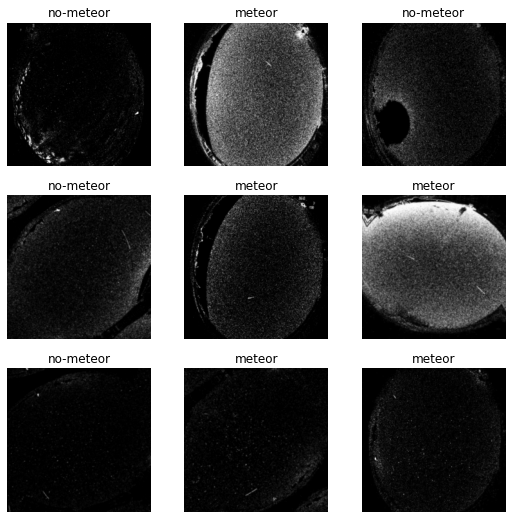

In [14]:
dls.show_batch()

In [15]:
learn = cnn_learner(dls, resnet34, 
                metrics=[error_rate, accuracy, Precision(average='macro'), F1Score(average='macro')],
                    cbs=[EarlyStoppingCallback(patience=25), ShowGraphCallback()]
                   )

In [16]:
print(learn.dls.train.after_batch)
print(learn.dls.valid.after_batch)

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}


In [17]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

SuggestedLRs(lr_min=0.0012589254416525363, lr_steep=3.981071756697929e-07)

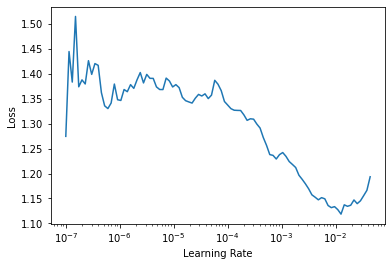

In [18]:
learn.lr_find(end_lr=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,f1_score,time
0,0.169496,0.190720,0.070288,0.929712,0.928999,0.929479,00:36


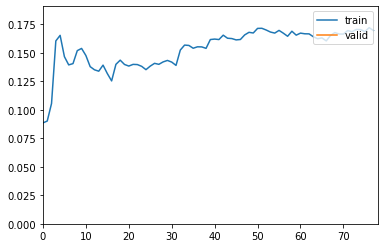

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,f1_score,time
0,0.149115,0.210243,0.068690,0.931310,0.930739,0.931162,00:45
1,0.158989,0.207059,0.073482,0.926518,0.925834,0.926246,00:48
2,0.167047,0.181749,0.063898,0.936102,0.935395,0.935913,00:50
3,0.165286,0.187046,0.063898,0.936102,0.935401,0.935890,00:48
4,0.164712,0.215156,0.079872,0.920128,0.919595,0.919767,00:48
5,0.160661,0.210774,0.070288,0.929712,0.928996,0.929505,01:10


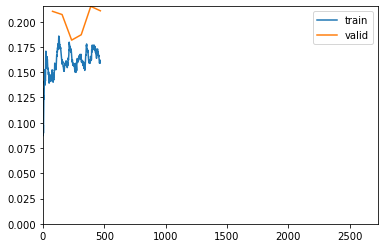

In [ ]:
learn.fine_tune(35,1*1e-3)

In [33]:
#Load or Save Model
#learn.export('C:/Development/guaita/guaita/guAIta_latest_version.pkl')
#learn = load_learner('C:/Development/guaita/guaita/guAIta_latest_version.pkl')

In [20]:
interp = ClassificationInterpretation.from_learner(learn, dl=learn.dls.test_dl(df[df["dataset"]=="test_set"], with_labels=True, bs=100))
interp.print_classification_report()

              precision    recall  f1-score   support

      meteor       0.81      0.91      0.86       300
   no-meteor       0.97      0.94      0.95      1000

    accuracy                           0.93      1300
   macro avg       0.89      0.93      0.91      1300
weighted avg       0.94      0.93      0.93      1300



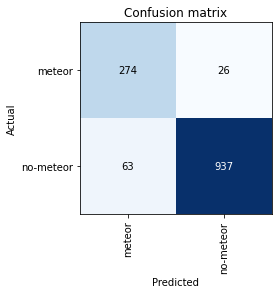

In [21]:
interp.plot_confusion_matrix(figsize=(4, 4))

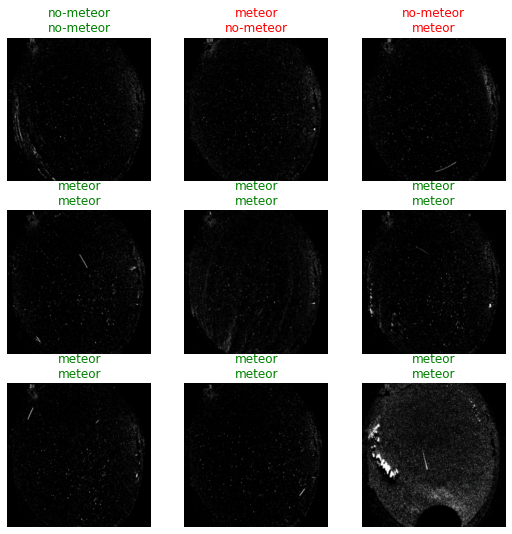

In [22]:
learn.show_results()

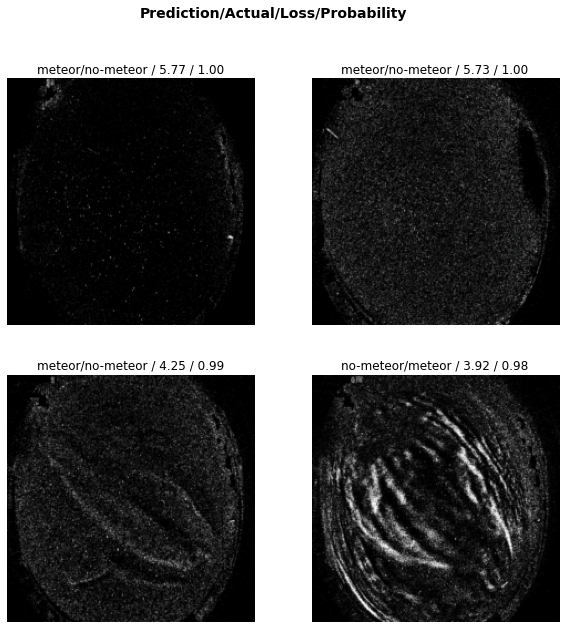

In [24]:
interp.plot_top_losses(k=4,figsize=(10,10))


In [28]:
losses,idxs = interp.top_losses(10)
df[df["dataset"]=="test_set"].iloc[idxs]

,fn,dataset,meteor
4659,\test_set\no-meteor\image-20210505004457.jpg,test_set,no-meteor
55,\test_set\meteor\image-20210419004000.jpg,test_set,meteor
280,\test_set\meteor\image-20210505041621.jpg,test_set,meteor
116,\test_set\meteor\image-20210423011210.jpg,test_set,meteor
281,\test_set\meteor\image-20210505041651.jpg,test_set,meteor
110,\test_set\meteor\image-20210419055134.jpg,test_set,meteor
2734,\test_set\no-meteor\image-20210423045608.jpg,test_set,no-meteor
4834,\test_set\no-meteor\image-20210505022007.jpg,test_set,no-meteor
4578,\test_set\no-meteor\image-20210505000022.jpg,test_set,no-meteor
271,\test_set\meteor\image-20210505033446.jpg,test_set,meteor


In [29]:
#Model Evaluation

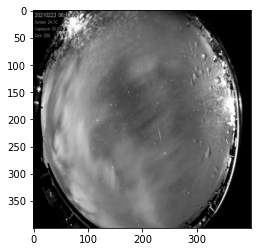

In [33]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/tractades/positive_4.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [26]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [27]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [34]:
cls = 0
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [35]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

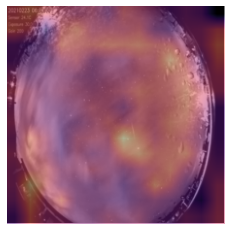

In [36]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.5, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [37]:
learn.predict(img)

('meteor', tensor(0), tensor([0.9539, 0.0461]))

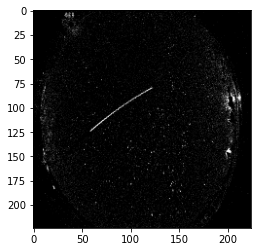

In [38]:
img = PILImage.create('C:/Development/meteor_detector/dataset/vDef_dia0504/test/my2.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [39]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored


In [40]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

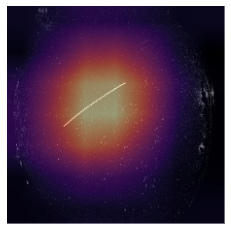

In [41]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [42]:
learn.predict(img)

('meteor', tensor(0), tensor([9.9990e-01, 9.6474e-05]))

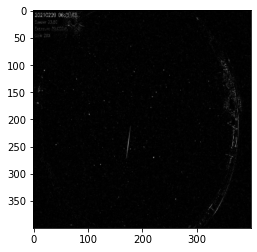

In [43]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/eliminat_fondo/positive_1.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [44]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored


In [45]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

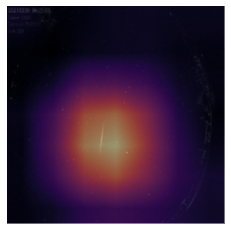

In [46]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [47]:
learn.predict(img)

('meteor', tensor(0), tensor([9.9923e-01, 7.7343e-04]))

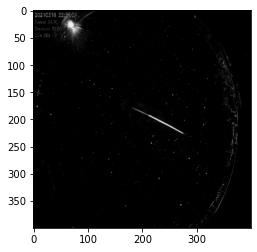

In [48]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/eliminat_fondo/positive_2.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

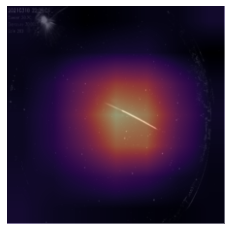

In [49]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [50]:
learn.predict(img)

('meteor', tensor(0), tensor([0.9973, 0.0027]))

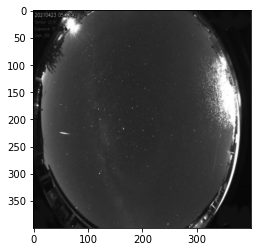

In [54]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/eliminat_fondo/positive_14.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

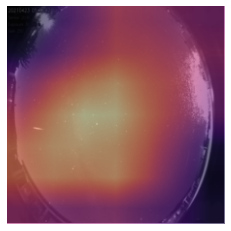

In [55]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [56]:
learn.predict(img)

('meteor', tensor(0), tensor([9.9961e-01, 3.8659e-04]))

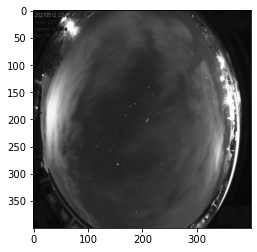

In [57]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/eliminat_fondo/positive_18.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

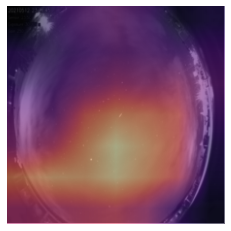

In [58]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [59]:
learn.predict(img)

('meteor', tensor(0), tensor([0.9965, 0.0035]))

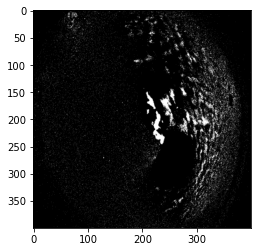

In [60]:
img = PILImage.create('C:/Development/meteor_detector/dataset/v7_adjusted/dataset/test_set/no-meteor/image-20210423001200.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [61]:
learn.predict(img)

('no-meteor', tensor(1), tensor([1.8918e-04, 9.9981e-01]))

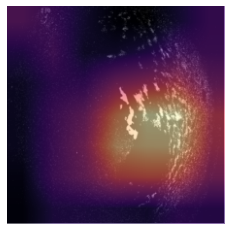

In [62]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

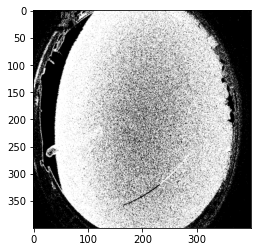

In [63]:
img = PILImage.create('C:/Development/meteor_detector/dataset/v7/dataset/test_set/meteor/image-20210321060030.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [64]:
learn.predict(img)

('meteor', tensor(0), tensor([0.9876, 0.0124]))

In [65]:
cls = 0
with HookBwd(learn.model[0][-1]) as hookg:
    with Hook(learn.model[0][-1]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [66]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

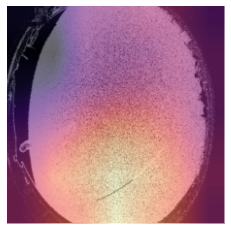

In [67]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

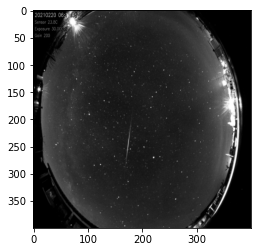

In [68]:
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/eliminat_fondo/positive_5.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [69]:
learn.predict(img)

('meteor', tensor(0), tensor([0.9989, 0.0011]))

In [70]:
cls = 0
with HookBwd(learn.model[0][-1]) as hookg:
    with Hook(learn.model[0][-1]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [71]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

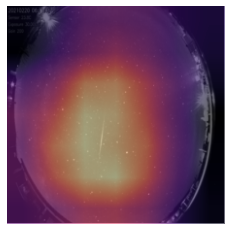

In [72]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

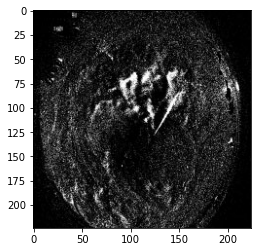

In [73]:
#Detection during pilot in Pujalt
img = PILImage.create('C:/Development/meteor_detector/dataset/Positius/pilot_detection.jpg')
x, = first(dls.test_dl([img]))
plt.imshow(img)

In [74]:
learn.predict(img)

('no-meteor', tensor(1), tensor([0.4404, 0.5596]))

In [75]:
cls = 0
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [76]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

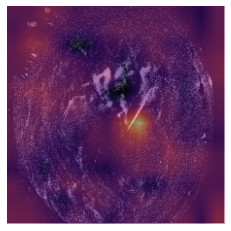

In [77]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [78]:
print(learn.model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  